In [1]:
from glob import glob
import os
from itertools import combinations

from tqdm import tqdm
import pandas as pd

In [2]:
sigles = [os.path.basename(fn).replace('.txt', '') for fn in glob('../data/plain_txt_martijn/*.txt')]
sigles = sorted(sigles)
sigles

['A',
 'Ant',
 'B',
 'BR',
 'C',
 'D',
 'D2',
 'E',
 'F',
 'Ge',
 'K',
 'L',
 'O',
 'W',
 'Y',
 'Z']

In [13]:
# even voor een kleinere groep
sigles = 'A', 'B', 'C'

In [14]:
mss = {}

for sigle in tqdm(sigles):
    ms = {}
    for line in open(f'../data/plain_txt_martijn/{sigle}.txt'):
        line = line.strip().lower()
        if not line or '...' in line or len(line) < 25:
            continue
        line_id, *tokens = line.split()
        try:
            line_id = int(line_id)
            ms[line_id] = ' '.join(tokens)
        except ValueError:
            pass
    if ms:
        mss[sigle] = ms

100%|██████████| 3/3 [00:00<00:00, 230.47it/s]


In [15]:
print(mss.keys())

dict_keys(['A', 'B', 'C'])


In [16]:
import numpy as np

# from: https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [17]:
distances = []

for ms1, ms2 in tqdm(list(combinations(mss.keys(), 2))):
    common_idxs = set(mss[ms1].keys()).intersection(set(mss[ms2].keys()))
    for idx in common_idxs:
        line1, line2 = mss[ms1][idx], mss[ms2][idx]
        #print('=================')
        #print(line1, '|', line2)
        rx, ry = nw(line1, line2)
        assert len(rx) == len(ry)
        #print('\n'.join([rx, ry]))
        length = len(rx)
        for idx, (a, b) in enumerate(zip(rx, ry)):
            if a != b:
                distances.append((ms1, ms2, idx/length, 1))
            else:
                distances.append((ms1, ms2, idx/length, 0))

100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


In [18]:
mismatches = pd.DataFrame(distances, columns=('ms1', 'ms2', 'position', 'mismatch'))
mismatches.head(30)

,ms1,ms2,position,mismatch
0,A,B,0.000000,0
1,A,B,0.037037,0
2,A,B,0.074074,0
3,A,B,0.111111,0
4,A,B,0.148148,0
5,A,B,0.185185,0
6,A,B,0.222222,0
7,A,B,0.259259,0
8,A,B,0.296296,0
9,A,B,0.333333,0


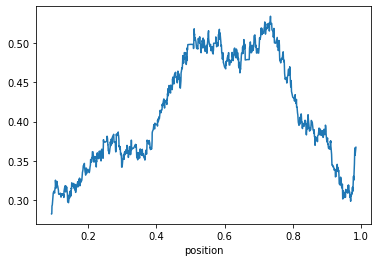

In [19]:
mismatches.groupby('position')['mismatch'].mean().rolling(window=100).mean().plot();